In [ ]:
!pip install tensorflow
!pip install scikit-learn
!pip install umap-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.2 MB/s eta 0:00:00


In [ ]:
# Importación de las librerías necesarias
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import os
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Concatenate

# Configuración de hiperparámetros
time_window = 24

# Nueva forma del input: 6 variables para contaminantes y 4 para meteorología
contaminant_input_shape = (time_window, 6)  # Contaminantes
meteorology_input_shape = (time_window, 4)  # Variables meteorológicas

def create_dcae_with_fusion(contaminant_input_shape, meteorology_input_shape):
    # Entrada para los contaminantes
    contaminant_input = Input(shape=contaminant_input_shape)
    x1 = Conv1D(64, kernel_size=10, activation='relu', padding='same')(contaminant_input)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Conv1D(12, kernel_size=5, activation='relu', padding='same')(x1)
    x1 = MaxPooling1D(pool_size=2)(x1)
    x1 = Flatten()(x1)

    # Entrada para las variables meteorológicas
    meteorology_input = Input(shape=meteorology_input_shape)
    x2 = Conv1D(64, kernel_size=10, activation='relu', padding='same')(meteorology_input)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Conv1D(32, kernel_size=5, activation='relu', padding='same')(x2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Conv1D(12, kernel_size=5, activation='relu', padding='same')(x2)
    x2 = MaxPooling1D(pool_size=2)(x2)
    x2 = Flatten()(x2)

    # Fusionar ambas ramas
    x = Concatenate()([x1, x2])
    encoded = Dense(60, activation='linear')(x)

    # Decoder
    x = Dense((time_window // 8) * 12, activation='relu')(encoded)
    x = Reshape((time_window // 8, 12))(x)
    x = Conv1D(12, kernel_size=5, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(32, kernel_size=5, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(64, kernel_size=10, activation='relu', padding='same')(x)
    x = UpSampling1D(size=2)(x)
    decoded = Conv1D(10, kernel_size=10, activation='linear', padding='same')(x)

    # Crear el modelo
    model = Model(inputs=[contaminant_input, meteorology_input], outputs=decoded)
    return model

# Crear y compilar el modelo
model = create_dcae_with_fusion(contaminant_input_shape, meteorology_input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23            │ (None, 24, 6)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_24            │ (None, 24, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_107 (Conv1D)       │ (None, 24, 64)         │          3,904 │ input_layer_23[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_110 (Conv1D)       │ (None, 24, 64)         │          2,624 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_66          │ (None, 12, 64)         │              0 │ conv1d_107[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_69          │ (None, 12, 64)         │              0 │ conv1d_110[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_108 (Conv1D)       │ (None, 12, 32)         │         10,272 │ max_pooling1d_66[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_111 (Conv1D)       │ (None, 12, 32)         │         10,272 │ max_pooling1d_69[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_67          │ (None, 6, 32)          │              0 │ conv1d_108[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_70          │ (None, 6, 32)          │              0 │ conv1d_111[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_109 (Conv1D)       │ (None, 6, 12)          │          1,932 │ max_pooling1d_67[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_112 (Conv1D)       │ (None, 6, 12)          │          1,932 │ max_pooling1d_70[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_68          │ (None, 3, 12)          │              0 │ conv1d_109[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_71          │ (None, 3, 12)          │              0 │ conv1d_112[0][0]       │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_22 (Flatten)      │ (None, 36)             │              0 │ max_pooling1d_68[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_23 (Flatten) 

 Total params: 67,150 (262.30 KB)

 Trainable params: 67,150 (262.30 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Modificación de la función de preprocesamiento
def preprocess_data_for_fusion(data, time_window):
    # Imputación de valores faltantes
    imputer = SimpleImputer(strategy='mean')
    data = imputer.fit_transform(data)

    # Normalización de los datos
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # División de las columnas en contaminantes y meteorológicas
    contaminant_data = data[:, :6]
    meteorology_data = data[:, 6:]

    # Creación de secuencias
    contaminant_sequences, meteorology_sequences = [], []
    combined_sequences = []

    for i in range(len(data) - time_window + 1):
        contaminant_sequences.append(contaminant_data[i:i + time_window])
        meteorology_sequences.append(meteorology_data[i:i + time_window])

        # Concatenar las secuencias en el último eje para formar la salida combinada de 10 características
        combined_sequences.append(data[i:i + time_window])

    contaminant_sequences = np.array(contaminant_sequences)
    meteorology_sequences = np.array(meteorology_sequences)
    combined_sequences = np.array(combined_sequences)

    return contaminant_sequences, meteorology_sequences, combined_sequences, scaler

# Ruta del archivo de datos
data_path = '/content/drive/MyDrive/Data_Beijing/Data_Wanshouxigong.csv'

# Cargar los datos de calidad del aire
air_quality_data = pd.read_csv(data_path)

# Seleccionar solo las columnas de interés
features = ['PM2_5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN']
air_quality_data = air_quality_data[features]

# Llamar a la función de preprocesamiento para obtener las secuencias y el scaler
# Llamar a la función de preprocesamiento para obtener las secuencias y el scaler
contaminant_sequences, meteorology_sequences, combined_sequences, scaler = preprocess_data_for_fusion(air_quality_data, time_window)


In [ ]:
# Número de filas antes del procesamiento
num_filas_antes = air_quality_data.shape[0]
print(f"Número de filas antes del procesamiento: {num_filas_antes}")
# Número de secuencias creadas (filas después del procesamiento)
num_filas_despues = combined_sequences.shape[0]
print(f"Número de filas después del procesamiento: {num_filas_despues}")

Número de filas antes del procesamiento: 35064
Número de filas después del procesamiento: 35041


In [ ]:
# Entrenar el modelo usando ambas entradas y la salida combinada
history = model.fit(
    [contaminant_sequences, meteorology_sequences],
    combined_sequences,
    epochs=50,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.3448 - val_loss: 0.2092
Epoch 2/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.1553 - val_loss: 0.1877
Epoch 3/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.1314 - val_loss: 0.1632
Epoch 4/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - loss: 0.1176 - val_loss: 0.1455
Epoch 5/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.1100 - val_loss: 0.1363
Epoch 6/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.1032 - val_loss: 0.1344
Epoch 7/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0979 - val_loss: 0.1224
Epoch 8/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0940 - val_loss: 0.1288
Epoch 9/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0914 - val_loss: 0.1185
Epoch 10/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.0911 - val_loss: 0.1165
Epoch 11/50
876/876 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0849 - val_loss: 0.1213
Epoch 12/50
876/876 ━━━━━━━━━━

In [ ]:
# Guardar el modelo en un archivo
model.save('/content/drive/MyDrive/Data_Beijing/Model/modelo_fusion_DCAE_2.h5')

print("Modelo guardado correctamente.")

Modelo guardado correctamente.


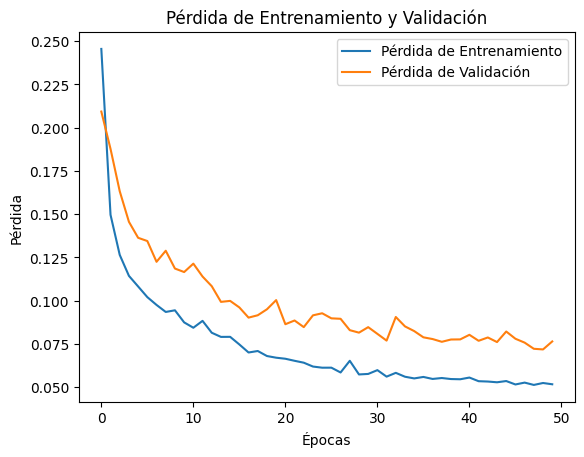

In [ ]:
import matplotlib.pyplot as plt

# Pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida de Entrenamiento y Validación')
plt.show()


In [ ]:
import pandas as pd

# Crear un DataFrame con los datos de pérdida y pérdida de validación
loss_data = {
    "Epoca": list(range(1, len(history.history['loss']) + 1)),
    "Perdida_Entrenamiento": history.history['loss'],
    "Perdida_Validacion": history.history['val_loss']
}
loss_df = pd.DataFrame(loss_data)

# Guardar el DataFrame en un archivo CSV
csv_path_loss = "/content/drive/MyDrive/Data_Beijing/Vector-Fusion/perdidas_entrenamiento_y_validacion.csv"
loss_df.to_csv(csv_path_loss, index=False)
csv_path_loss


'/content/drive/MyDrive/Data_Beijing/Vector-Fusion/perdidas_entrenamiento_y_validacion.csv'

In [ ]:
# Reducción de dimensionalidad y visualización
def visualize_encoded_data(encoded_data):
    """
    Aplica métodos de reducción de dimensionalidad: PCA, t-SNE y UMAP.
    """
    pca = PCA(n_components=2)
    tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
    umap_reducer = umap.UMAP(n_components=2)

    pca_result = pca.fit_transform(encoded_data)
    tsne_result = tsne.fit_transform(encoded_data)
    umap_result = umap_reducer.fit_transform(encoded_data)

    return pca_result, tsne_result, umap_result

# Extraer características del encoder para la reducción de dimensionalidad
encoder = Model(inputs=model.input, outputs=model.get_layer('dense_20').output)
encoded_data = encoder.predict([contaminant_sequences, meteorology_sequences])

# Reducción de dimensionalidad
pca_result, tsne_result, umap_result = visualize_encoded_data(encoded_data)


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
# Crear la carpeta "/content/drive/MyDrive/Data_Beijing/Vector" si no existe
output_path = '/content/drive/MyDrive/Data_Beijing/Vector-Fusion'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Guardar los resultados de las reducciones de dimensionalidad en CSV
np.savetxt(os.path.join(output_path, 'pca_result.csv'), pca_result, delimiter=',', header="PCA1,PCA2", comments='')
np.savetxt(os.path.join(output_path, 'tsne_result.csv'), tsne_result, delimiter=',', header="tSNE1,tSNE2", comments='')
np.savetxt(os.path.join(output_path, 'umap_result.csv'), umap_result, delimiter=',', header="UMAP1,UMAP2", comments='')

# Guardar las características codificadas en un CSV
np.savetxt(os.path.join(output_path, 'encoded_features.csv'), encoded_data, delimiter=',', header="Feature_" + ','.join(map(str, range(encoded_data.shape[1]))), comments='')

# Visualización de PCA
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='purple', label='PCA')
plt.title('PCA Result')
plt.savefig(os.path.join(output_path, 'pca_plot.png'))
plt.show()

# Visualización de t-SNE
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', label='t-SNE')
plt.title('t-SNE Result')
plt.savefig(os.path.join(output_path, 'tsne_plot.png'))
plt.show()

# Visualización de UMAP
plt.scatter(umap_result[:, 0], umap_result[:, 1], c='grey', label='UMAP')
plt.title('UMAP Result')
plt.savefig(os.path.join(output_path, 'umap_plot.png'))
plt.show()


NameError: name 'pca_result' is not defined

In [ ]:
# Contar las filas de los archivos guardados
files = ['pca_result.csv', 'tsne_result.csv', 'umap_result.csv', 'encoded_features.csv']

for file in files:
    file_path = os.path.join(output_path, file)
    num_rows = sum(1 for line in open(file_path)) - 1
    print(f'{file} tiene {num_rows} filas')

pca_result.csv tiene 35041 filas
tsne_result.csv tiene 35041 filas
umap_result.csv tiene 35041 filas
encoded_features.csv tiene 35041 filas


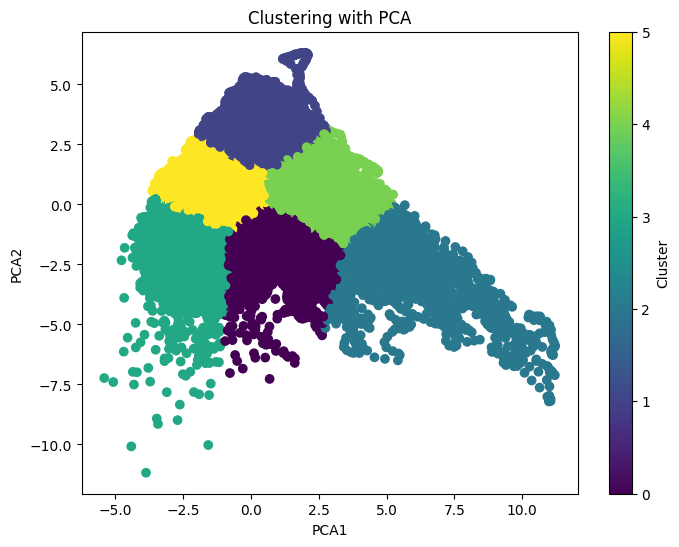

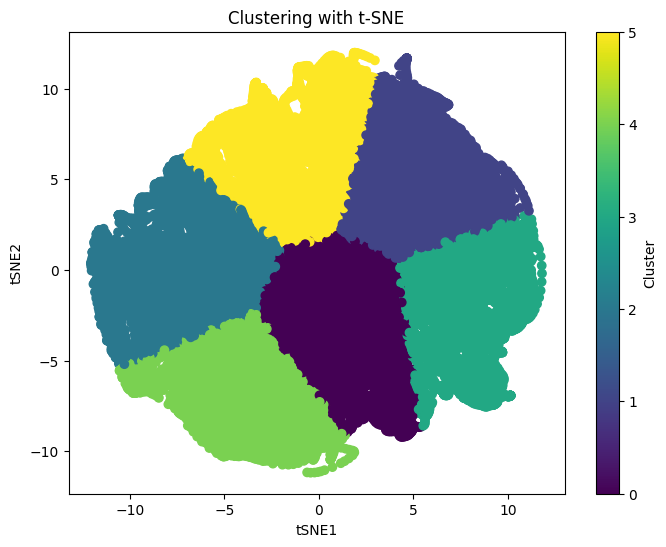

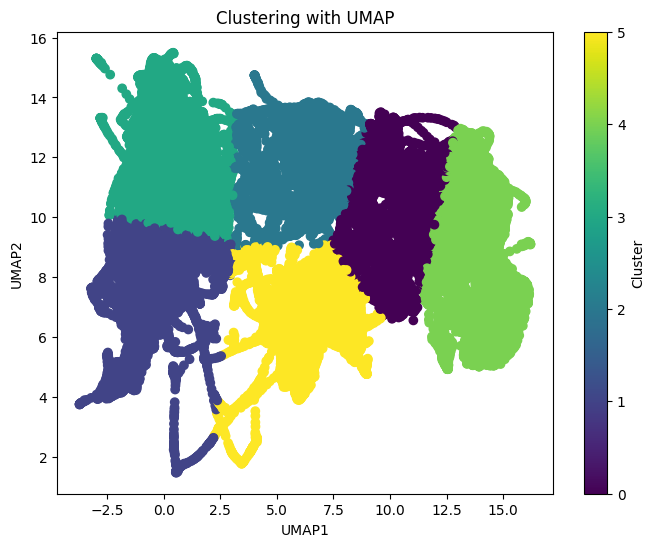

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Crear la carpeta si no existe
output_path = '/content/drive/MyDrive/Data_Beijing/Vector-Fusion'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Definir el número de clusters
n_clusters = 6

# Aplicar KMeans clustering a los resultados de PCA, t-SNE y UMAP
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_result)
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42).fit(tsne_result)
kmeans_umap = KMeans(n_clusters=n_clusters, random_state=42).fit(umap_result)

# Obtener las etiquetas de los clusters
labels_pca = kmeans_pca.labels_
labels_tsne = kmeans_tsne.labels_
labels_umap = kmeans_umap.labels_

# Visualización de PCA con los clusters
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels_pca, cmap='viridis', label='PCA Clusters')
plt.title('Clustering with PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.savefig(os.path.join(output_path, 'pca_clusters.png'))
plt.show()

# Visualización de t-SNE con los clusters
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels_tsne, cmap='viridis', label='t-SNE Clusters')
plt.title('Clustering with t-SNE')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.colorbar(label='Cluster')
plt.savefig(os.path.join(output_path, 'tsne_clusters.png'))
plt.show()

# Visualización de UMAP con los clusters
plt.figure(figsize=(8, 6))
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels_umap, cmap='viridis', label='UMAP Clusters')
plt.title('Clustering with UMAP')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.savefig(os.path.join(output_path, 'umap_clusters.png'))
plt.show()

# Guardar los resultados de los clusters en CSV
np.savetxt(os.path.join(output_path, 'pca_clusters.csv'), np.column_stack([pca_result, labels_pca]), delimiter=',', header="PCA1,PCA2,Cluster", comments='')
np.savetxt(os.path.join(output_path, 'tsne_clusters.csv'), np.column_stack([tsne_result, labels_tsne]), delimiter=',', header="tSNE1,tSNE2,Cluster", comments='')
np.savetxt(os.path.join(output_path, 'umap_clusters.csv'), np.column_stack([umap_result, labels_umap]), delimiter=',', header="UMAP1,UMAP2,Cluster", comments='')


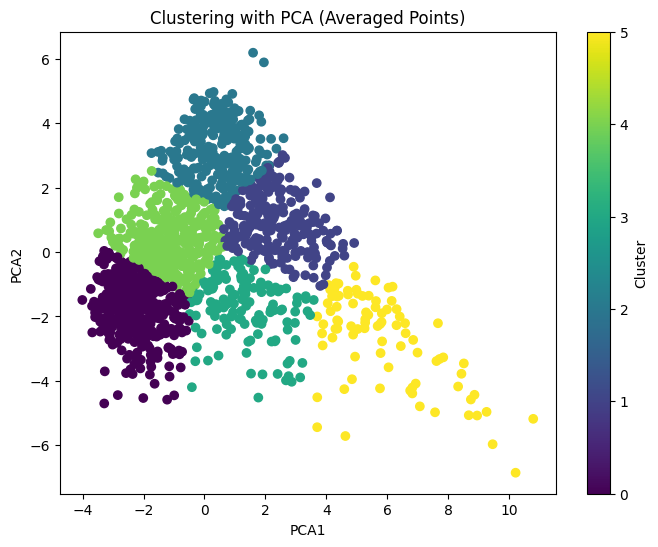

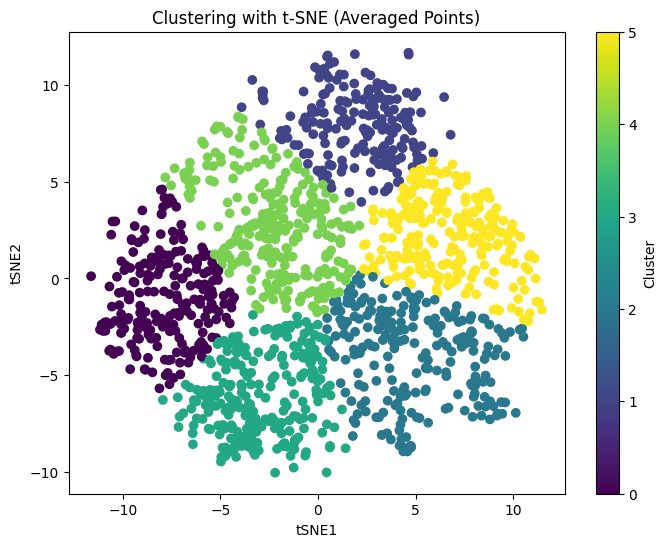

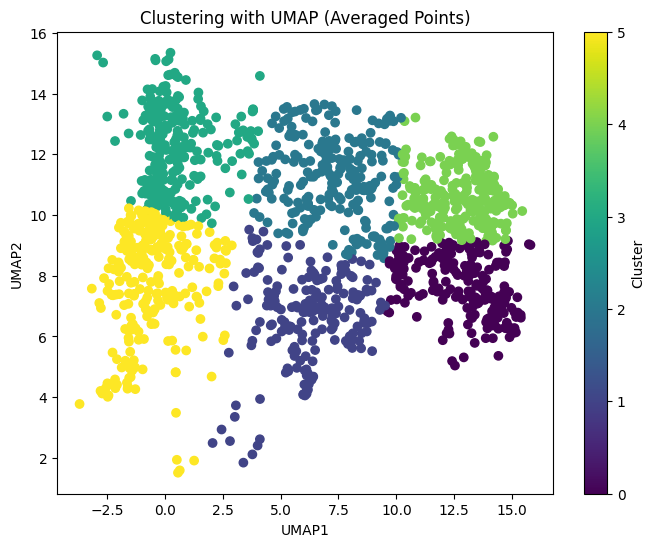

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Crear la carpeta si no existe
output_path = '/content/drive/MyDrive/Data_Beijing/Vector-Fusion'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Definir el número de clusters
n_clusters = 6

# Función para calcular el promedio de cada 24 puntos
def average_points(data, n=24):
    averaged_data = []
    for i in range(0, len(data), n):
        # Tomamos el bloque de 24 puntos (o menos si no es múltiplo de 24)
        block = data[i:i+n]
        # Calculamos el promedio de cada bloque
        averaged_data.append(np.mean(block, axis=0))
    return np.array(averaged_data)

# Promediar los resultados de PCA, t-SNE y UMAP
pca_avg = average_points(pca_result)
tsne_avg = average_points(tsne_result)
umap_avg = average_points(umap_result)

# Aplicar KMeans clustering a los resultados promediados de PCA, t-SNE y UMAP
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_avg)
kmeans_tsne = KMeans(n_clusters=n_clusters, random_state=42).fit(tsne_avg)
kmeans_umap = KMeans(n_clusters=n_clusters, random_state=42).fit(umap_avg)

# Obtener las etiquetas de los clusters
labels_pca = kmeans_pca.labels_
labels_tsne = kmeans_tsne.labels_
labels_umap = kmeans_umap.labels_

# Visualización de PCA con los clusters promediados
plt.figure(figsize=(8, 6))
plt.scatter(pca_avg[:, 0], pca_avg[:, 1], c=labels_pca, cmap='viridis', label='PCA Clusters')
plt.title('Clustering with PCA (Averaged Points)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.colorbar(label='Cluster')
plt.savefig(os.path.join(output_path, 'pca_clusters_avg.png'))
plt.show()

# Visualización de t-SNE con los clusters promediados
plt.figure(figsize=(8, 6))
plt.scatter(tsne_avg[:, 0], tsne_avg[:, 1], c=labels_tsne, cmap='viridis', label='t-SNE Clusters')
plt.title('Clustering with t-SNE (Averaged Points)')
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')
plt.colorbar(label='Cluster')
plt.savefig(os.path.join(output_path, 'tsne_clusters_avg.png'))
plt.show()

# Visualización de UMAP con los clusters promediados
plt.figure(figsize=(8, 6))
plt.scatter(umap_avg[:, 0], umap_avg[:, 1], c=labels_umap, cmap='viridis', label='UMAP Clusters')
plt.title('Clustering with UMAP (Averaged Points)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.savefig(os.path.join(output_path, 'umap_clusters_avg.png'))
plt.show()

# Guardar los resultados de los clusters promediados en CSV
np.savetxt(os.path.join(output_path, 'pca_clusters_avg.csv'), np.column_stack([pca_avg, labels_pca]), delimiter=',', header="PCA1,PCA2,Cluster", comments='')
np.savetxt(os.path.join(output_path, 'tsne_clusters_avg.csv'), np.column_stack([tsne_avg, labels_tsne]), delimiter=',', header="tSNE1,tSNE2,Cluster", comments='')
np.savetxt(os.path.join(output_path, 'umap_clusters_avg.csv'), np.column_stack([umap_avg, labels_umap]), delimiter=',', header="UMAP1,UMAP2,Cluster", comments='')


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Method  Trustworthiness  Continuity
0    PCA         0.809577     0.08678
1  t-SNE         0.933291     0.28826
2   UMAP         0.935682     0.22164


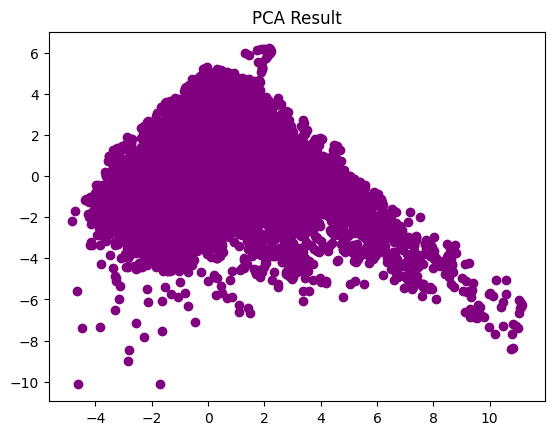

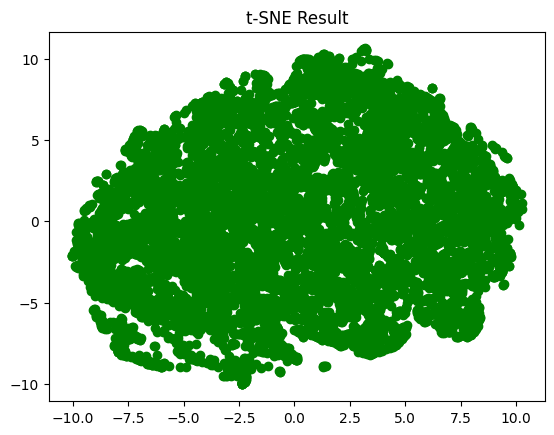

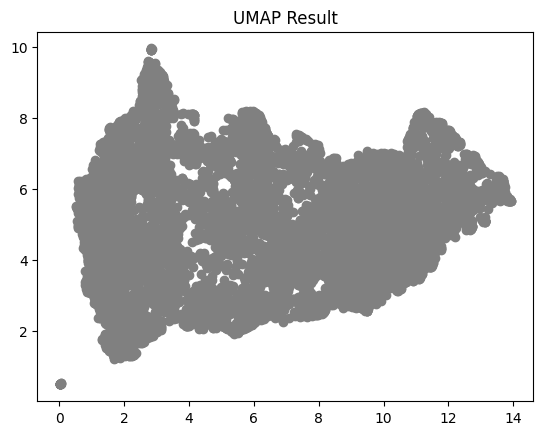

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, trustworthiness
from umap import UMAP
from scipy.spatial.distance import cdist

# Ruta de salida
output_path = '/content/drive/MyDrive/Data_Beijing/Vector-Fusion'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Leer las características codificadas desde el archivo CSV
encoded_file_path = os.path.join(output_path, 'encoded_features.csv')
encoded_data = np.loadtxt(encoded_file_path, delimiter=',', skiprows=1)

# Reducir el tamaño del dataset si es demasiado grande
if encoded_data.shape[0] > 10000:  # Limitar a 10,000 muestras
    np.random.seed(42)
    indices = np.random.choice(encoded_data.shape[0], 10000, replace=False)
    encoded_data = encoded_data[indices]

# Aplicar reducción de dimensionalidad
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_data)
np.savetxt(os.path.join(output_path, 'pca_result.csv'), pca_result, delimiter=',', header="PCA1,PCA2", comments='')

# t-SNE
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    tsne_result = tsne.fit_transform(encoded_data)
    np.savetxt(os.path.join(output_path, 'tsne_result.csv'), tsne_result, delimiter=',', header="tSNE1,tSNE2", comments='')
except Exception as e:
    print("Error al ejecutar t-SNE:", e)
    tsne_result = None

# UMAP
try:
    umap = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    umap_result = umap.fit_transform(encoded_data)
    np.savetxt(os.path.join(output_path, 'umap_result.csv'), umap_result, delimiter=',', header="UMAP1,UMAP2", comments='')
except Exception as e:
    print("Error al ejecutar UMAP:", e)
    umap_result = None

# Calcular métricas de evaluación
metrics = []

# Trustworthiness
def calculate_trustworthiness(data, reduced_data, method_name):
    try:
        return trustworthiness(data, reduced_data, n_neighbors=5)
    except Exception as e:
        print(f"Error al calcular trustworthiness para {method_name}:", e)
        return None

trust_pca = calculate_trustworthiness(encoded_data, pca_result, "PCA")
trust_tsne = calculate_trustworthiness(encoded_data, tsne_result, "t-SNE") if tsne_result is not None else None
trust_umap = calculate_trustworthiness(encoded_data, umap_result, "UMAP") if umap_result is not None else None

# Continuity (cálculo personalizado)
def continuity(original_data, reduced_data, n_neighbors=5):
    try:
        dist_original = cdist(original_data, original_data)
        dist_reduced = cdist(reduced_data, reduced_data)
        original_indices = np.argsort(dist_original, axis=1)[:, 1:n_neighbors+1]
        reduced_indices = np.argsort(dist_reduced, axis=1)[:, 1:n_neighbors+1]
        matches = [len(set(original_indices[i]).intersection(set(reduced_indices[i]))) / n_neighbors for i in range(original_data.shape[0])]
        return np.mean(matches)
    except Exception as e:
        print("Error al calcular continuity:", e)
        return None

cont_pca = continuity(encoded_data, pca_result, n_neighbors=5)
cont_tsne = continuity(encoded_data, tsne_result, n_neighbors=5) if tsne_result is not None else None
cont_umap = continuity(encoded_data, umap_result, n_neighbors=5) if umap_result is not None else None

# Almacenar métricas
metrics.append(["PCA", trust_pca, cont_pca])
if tsne_result is not None:
    metrics.append(["t-SNE", trust_tsne, cont_tsne])
if umap_result is not None:
    metrics.append(["UMAP", trust_umap, cont_umap])

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metrics, columns=["Method", "Trustworthiness", "Continuity"])

# Guardar las métricas en un archivo CSV
results_csv_path = os.path.join(output_path, 'results.csv')
metrics_df.to_csv(results_csv_path, index=False)

# Mostrar la tabla en consola
print(metrics_df)

# Visualización
if pca_result is not None:
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c='purple', label='PCA')
    plt.title('PCA Result')
    plt.savefig(os.path.join(output_path, 'pca_plot.png'))
    plt.show()

if tsne_result is not None:
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c='green', label='t-SNE')
    plt.title('t-SNE Result')
    plt.savefig(os.path.join(output_path, 'tsne_plot.png'))
    plt.show()

if umap_result is not None:
    plt.scatter(umap_result[:, 0], umap_result[:, 1], c='grey', label='UMAP')
    plt.title('UMAP Result')
    plt.savefig(os.path.join(output_path, 'umap_plot.png'))
    plt.show()
